# Hedge strategy on a given price path
We continue to work within the Black/Scholes model, so the price of the underlying stock follows Geometric Brownian motion as above.

**Task**

Using the scaffold provided, write a Python function which calculates the terminal profit or loss from a strategy which involves selling a European call or put option at time 0 and hedging it by a Black/Scholes delta-hedging strategy with rebalancing at discrete time points, as described in the section "Black/Scholes hedging in practice" of Lecture 5. The function takes six arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$ and a 1 for a call or $-1$ for a put. Note that here, $S$ is a NumPy array of underlying stock prices
$$
S(t_i),\quad 0\leq i\leq n, t_0=0, t_n=T
$$
representing the price of the underlying stock at each time point at which the hedge is rebalanced, as well as the initial time point 0 and the terminal time point $T$, with the latter equal to the time of expiry of the option. 

**Example**
As you can see in the scaffold code, when you run the code, the array of underlying stock prices is read from a file called `stockpath.csv`. In the scaffold, $\sigma$, $r$ and $T$ are set to be consistent with the data in `stockpath.csv`. If your Python function is implemented correctly, you should obtain the following:

`Enter the strike price: 100
Enter 1 for call or -1 for put option: 1
The profit/loss from the hedged option position is 3.7001921391491273`

Note that when your code is marked, there is a tolerance of 0.00001 to allow for cumulative machine precision errors in different implementations.

In [118]:
# Using numba to speed up the Monte Carlo
import numpy as np
import pandas as pd
from numba import njit
from math import fabs, erf, erfc

NPY_SQRT1_2 = 1.0/ np.sqrt(2)

@njit(cache=True, fastmath=True)
def N(a):
    """
    Implementation of a faster computation of the standard normal cdf that works with numba.
    Source : https://github.com/cuemacro/teaching/blob/master/pythoncourse/notebooks/numba_example.ipynb
    """

    if (np.isnan(a)):
        return np.nan

    x = a * NPY_SQRT1_2;
    z = fabs(x)

    if (z < NPY_SQRT1_2):
        y = 0.5 + 0.5 * erf(x)

    else:
        y = 0.5 * erfc(z)

        if (x > 0):
            y = 1.0 - y

    return y


@njit(cache=True)
def D1(S, K, T, r, sgm):
    return (np.log(S / K) + (r + sgm**2 / 2) * T) / (sgm * np.sqrt(T))


@njit(cache=True)
def D2(S, K, T, r, sgm):
    return D1(S, K, T, r, sgm) - sgm * np.sqrt(T)


@njit(cache=True)
def BlackScholesHedgePath(S, K, sgm, r, T, callput):

    maturities = np.linspace(0, T, len(S))

    d1 = D1(S[:-1], K, T - maturities[:-1], r, sgm)
    d2 = D2(S[:-1], K, T - maturities[:-1], r, sgm)

    PnL = np.ones(len(S[1:-1]))

    for i in range(len(S[1:-1])):
        PnL[i] = callput * (
            (S[1:-1][i] * (N(callput * d1[:-1][i]) - N(callput * d1[1:][i])))
            - (
                K
                * np.exp(-r * (T - maturities[1:-1][i]))
                * (N(callput * d2[:-1][i]) - N(callput * d2[1:][i]))
            )
        )
    PnL = np.append(
        PnL,
        callput
        * (
            S[-1] * N(callput * d1[-1])
            - K * N(callput * d2[-1])
            - max(0, callput * (S[-1] - K))
        ),
    )

    return np.dot(PnL, np.exp(r * (T - maturities[1:])))


stockdata = pd.read_csv("stockpath.csv")
stock = np.array(stockdata["S(t)"])
strike = float(input('Enter the strike price: '))
sigma = 0.3
interest = 0.05
maturity = 2
callput = int(input('Enter 1 for call or -1 for put option: '))
PnL = BlackScholesHedgePath(stock, strike, sigma, interest, maturity, callput)
print("The profit/loss from the hedged option position is " + str(PnL))

The profit/loss from the hedged option position is 3.7001921391495367


# Monte Carlo simulation
The goal is to calculate the expected value of a function $f(\cdot)$ of a random variable $x$, where the distribution of $x$ is given by the probability density $\psi(x)$, i.e.
$$
E[f(x)]=\int_{-\infty}^{\infty}f(x)\psi(x)dx
$$

## Outline of the Monte Carlo simulation
1. Establish a procedure for drawing variates $x$ from the target distribution $\psi(x)$.
2. Initialise the variables:
   RunningSum = 0 
   RunningSumSquared = 0 
   $i=1$
3. Draw a realisation $x_i$ from the target distribution.
4. Add $f(x_i)$ to RunningSum and  $(f(x_i))^2$ to RunningSumSquared.
5. Increment the counter $i$. If $i$ is less than the maximum number of iterations, go to step 3.
6. Calculate the simulated mean by dividing RunningSum by the total number of iterations.
7. Calculate the variance of the simulations by dividing RunningSumSquared by the total number of iterations and subtracting the square of the mean.

## Error estimation for Monte Carlo methods
By the Central Limit Theorem, we know that for a large number $N$ of simulations, the simulation mean $X_N$ is approximately normally distributed, with standard deviation
$$
\sqrt{\frac{\sigma^2}N}
$$
where the simulation variance is an estimate for $\sigma^2$.

Thus, if there is no bias, the simulation mean is normally distributed around the target value with a standard deviation, which decreases with $\sqrt{N}$.

A 95% confidence interval for the target value is therefore approximately given by
$$
\left[X_N-2\sqrt{\frac{\sigma^2}N};X_N+2\sqrt{\frac{\sigma^2}N}\right]
$$

<font color='red'>**Monte Carlo simulation without error bounds is meaningless!**</font>

The NumPy function `random.standard_normal()` returns a random variate drawn from the standard normal distribution, while `random.standard_normal(n)` returns `n` such variates in a Numpy array:

In [119]:
print(np.random.standard_normal())
n = 5
print(np.random.standard_normal(n))

-2.055156168122564
[ 0.08057807  0.71605237  0.87332163  0.80664127 -0.00955625]


Recall that a standard normal random variable can be converted into a normal random variable of desired mean and standard deviation by multiplying by the standard deviation and adding the mean.

## Monte Carlo pricing of a Black/Scholes call option
In the Black/Scholes model, the price of the underlying stock follows Geometric Brownian motion, with the dynamics under the risk-neutral measure given by
$$S(T)=S(t)\exp\left\{\left(r−\frac12\sigma^2\right)(T−t)+\sigma(W(T)−W(t))\right\}$$
Recall that the time 0 price of a European call option (and analogously the put option) expiring at time $T$ with strike price $K$ can be expressed as the expectation under the risk-neutral measure of 
$$C=E\left[e^{−rT}\max(0,S(T)−K)\right]$$
Thus we can write a Python function which calculates the Monte Carlo estimate `MC` for the Black/Scholes price of the option and the standard deviation `MCstd` of the simulation mean, where the function takes seven arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$, a 1 for a call or -1 for a put, and $n$, the number of sampling iterations of the Monte Carlo algorithm:

In [120]:
def BlackScholesMC(S, K, sgm, r, T, callput, n):
    w = np.random.standard_normal(n)
    ST = S * np.exp((r - 0.5 * sgm**2) * T + sgm * np.sqrt(T) * w)
    payoff = callput * (ST - K)
    payoff = payoff * (payoff > 0)
    MC = np.exp(-r * T) * np.mean(payoff)
    MCstd = np.exp(-r * T) * np.std(payoff) / np.sqrt(n)
    return MC, MCstd

To run this code with user inputs:

In [121]:
stock = float(input("Enter the underlying stock price: "))
strike = float(input("Enter the strike price: "))
sigma = float(input("Enter the volatility: "))
interest = float(input("Enter continuously compounded interest rate: "))
maturity = float(input("Enter the time to maturity: "))
callput = int(input("Enter 1 for call or -1 for put option: "))
n = int(input("Enter the number of simulations: "))
# stock,strike,sigma,interest,maturity,callput,mu,n = 100, 105, 0.3, 0.02, 2, 1, 0.07, 10000
MC, MCstd = BlackScholesMC(stock, strike, sigma, interest, maturity, callput, n)
print("The MC estimate for the option price is: ")
print(MC)
print("The 2 standard deviation confidence interval for the option price is: ")
print(MC - 2 * MCstd, MC + 2 * MCstd)

The MC estimate for the option price is: 
16.338549147437572
The 2 standard deviation confidence interval for the option price is: 
15.689002026051847 16.988096268823295


# Monte Carlo simulation of Black/Scholes hedging
Using the scaffold provided, write a Python function which calculates the Monte Carlo estimate `MC` for the expected terminal profit or loss from a strategy which involves selling a European call or put option at time 0 and hedging it by a Black/Scholes delta-hedging strategy with rebalancing at discrete time points, as described in the section "Black/Scholes hedging in practice" of Lecture 5. The function should also return the standard deviation `MCstd` of the simulation mean. The function takes nine arguments (in this order): $S$, $K$, $\sigma$, $r$, $T$, a 1 for a call or $-1$ for a put, the drift $\mu$ of the stock price process under the objective (not the risk-neutral) probability measure, the number of sampling iterations of the Monte Carlo algorithm $n$, and the number of time steps $m$ on each simulated price path. 

Note that here $S$ is the initial (time 0) stock price, and your function needs to generate $n$ sample paths of the stock price dynamics unter the objective probability measure, i.e. according to the dynamics
$$
S(T)=S(t)\exp\left\{(μ−\frac12\sigma^2)(T−t)+\sigma(W(T)−W(t))\right\}
$$
This reflects the fact that this is a risk management application, not a pricing application, so we are interested in the uncertainty of the terminal profit/loss under the objective probabilities.

In [122]:
def BlackScholesHedgeMC(S, K, sgm, r, T, callput, mu, n, m):
    w = np.random.standard_normal((n, m))
    St = np.empty((n, m + 1))
    St[:,0] = S
    for i in range(m):
        St[:,i+1] = St[:,i] * np.exp((mu - .5 * sgm**2) * (T / m) + sgm * (w[:,i]) * np.sqrt(T / m))
    payoff = np.apply_along_axis(BlackScholesHedgePath, 1, St, K, sgm, r, T, callput)
    return np.mean(payoff), np.std(payoff) / np.sqrt(n)

stock,strike,sigma,interest,maturity,callput,mu,n, m = 100, 105, 0.3, 0.02, 2, 1, 0.07, 10000, 100

# stock = float(input("Enter the underlying stock price: "))
# strike = float(input("Enter the strike price: "))
# sigma = float(input("Enter the volatility: "))
# interest = float(input("Enter continuously compounded interest rate: "))
# maturity = float(input("Enter the time to maturity: "))
# callput = int(input("Enter 1 for call or -1 for put option: "))
# mu = float(input("Enter the drift mu: "))
# n = int(input("Enter the number of simulations: "))
# m = int(input("Enter the number of time steps: "))
MC, MCstd = BlackScholesHedgeMC(
    stock, strike, sigma, interest, maturity, callput, mu, n, m
)
print("The average simulated profit/loss is: ")
print(MC)
print("The 2 standard deviation confidence interval for the mean profit/loss is: ")
print(MC - 2 * MCstd, MC + 2 * MCstd)

The average simulated profit/loss is: 
-0.006474574144097656
The 2 standard deviation confidence interval for the mean profit/loss is: 
-0.03740522281769831 0.024456074529502998


# Visualising the profit/loss distribution
Adapt the Monte Carlo code you have written to generate the data for plotting a histogram of the profit/loss distribution of the hedged position, allowing for the same set of user inputs as in the above example. Plot the histogram.

The average simulated profit/loss is: 
0.0052178335374524825
The 2 standard deviation confidence interval for the mean profit/loss is: 
-0.02524424066076294 0.035679907735667905


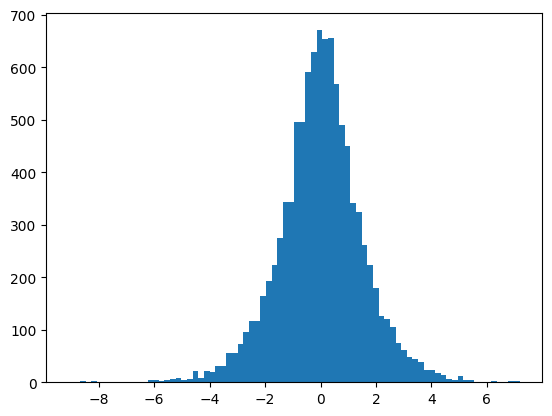

In [123]:
import matplotlib.pyplot as plt

def BlackScholesHedgeMC(S, K, sgm, r, T, callput, mu, n, m):
    w = np.random.standard_normal((n, m))
    St = np.empty((n, m + 1))
    St[:,0] = S
    for i in range(m):
        St[:,i+1] = St[:,i] * np.exp((mu - .5 * sgm**2) * (T / m) + sgm * (w[:,i]) * np.sqrt(T / m))
    payoff = np.apply_along_axis(BlackScholesHedgePath, 1, St, K, sgm, r, T, callput)
    return np.mean(payoff), np.std(payoff) / np.sqrt(n), payoff

stock,strike,sigma,interest,maturity,callput,mu,n,m = 100, 105, 0.3, 0.02, 2, 1, 0.07, 10000, 100

MC, MCstd, distribution = BlackScholesHedgeMC(
    stock, strike, sigma, interest, maturity, callput, mu, n, m
)
print("The average simulated profit/loss is: ")
print(MC)
print("The 2 standard deviation confidence interval for the mean profit/loss is: ")
print(MC - 2 * MCstd, MC + 2 * MCstd)

plt.hist(distribution, bins=80)
plt.show()

# Analysing the profit/loss distribution
Using the code you have written (adapting it if necessary), please answer the following questions:


1. What happens to the profit/loss (P/L) distribution of the hedged position when you increase or decrease the number of time steps? Why do you think this is so?
2. What happens to P/L distribution if you change $\mu$ in the objective measure dynamics? Why do you think this is so?
3. What happens to P/L distribution if you hedge based on a lower volatility than you use to generate the Monte Carlo paths? If you hedge using a higher volatility? Why do you think this is so?

Please add code and "Markdown" cells for your code and text answers below - <font color='red'>**remember not to overwrite your answers to previous questions above!**</font>

### 1- Playing with the number of time steps:

In [124]:
# 1
times = np.linspace(2, 200, 50)
mean_vect = []
std_vect = []
distribution_vect = []

stock,strike,sigma,interest,maturity,callput,mu,n = 100, 105, 0.3, 0.02, 2, 1, 0.07, 10000
for time in times:
    MC, MCstd, distribution = BlackScholesHedgeMC(
        stock, strike, sigma, interest, maturity, callput, mu, n, int(time)
    )
    mean_vect.append(MC)
    std_vect.append(MCstd)
    distribution_vect.append(distribution)

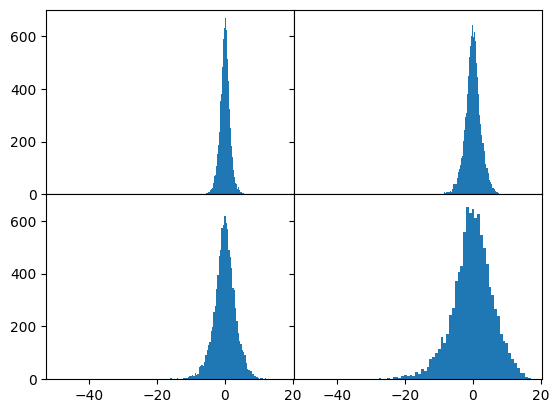

In [125]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex=True, sharey=True)
ax1.hist(distribution_vect[int(len(distribution_vect)/2)], bins=80)
ax2.hist(distribution_vect[10], bins=80)
ax3.hist(distribution_vect[5], bins=80)
ax4.hist(distribution_vect[1], bins=80)
plt.show()

We see that decreasing the number of time steps contributes to a higher std and a slight skew to the right when close to only one time step.

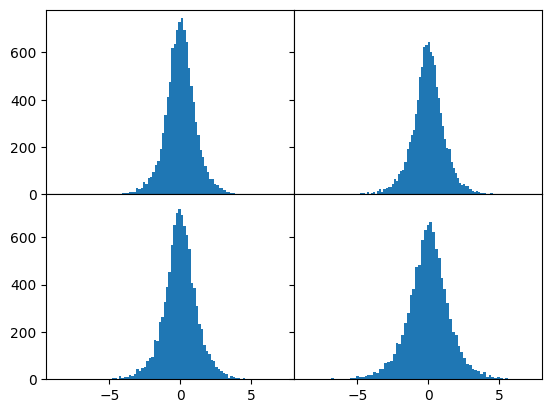

In [126]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex=True, sharey=True)
ax4.hist(distribution_vect[int(len(distribution_vect)/2)], bins=80)
ax3.hist(distribution_vect[-10], bins=80)
ax2.hist(distribution_vect[-5], bins=80)
ax1.hist(distribution_vect[-1], bins=80)
plt.show()

Increasing the number of time steps on the other hand seems to decrease the standard deviation and make the distribution tend to something approximating a Dirac function.

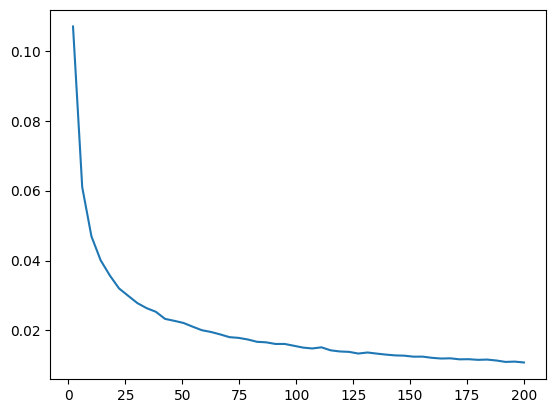

In [127]:
plt.plot(times, std_vect)
plt.show()

Indeed when we take a look at the standard deviation of the distribution, we can see that roughly, the standard deviation with respect to the number of time steps has the shape of $f(x) = \frac{1}{x}$
This is explained by the fact that since we don't change the maturity, the only thing we are doing when increasing the time steps is lowering the time between each rebalancing, therefore making the hedge slowly tend to a perfect continuous hedge. In fact, if the hedge was continuous and our time steps were infinitesimal, we would have the stock path as a pure brownian motion and not a discrete approximation, Therefore no matter the path we take the hedge PnL would always be 0 since we rebalance every instant and hedge until the next instant.

### 2- Playing with $\mu$

In [128]:
mus = np.linspace(0.001, 0.3, 300)
mean_vect = []
std_vect = []
distribution_vect = []

stock,strike,sigma,interest,maturity,callput,n, m = 100, 105, 0.3, 0.02, 2, 1, 10000, 100
for mu in mus:
    MC, MCstd, distribution = BlackScholesHedgeMC(
        stock, strike, sigma, interest, maturity, callput, mu, n, m
    )
    mean_vect.append(MC)
    std_vect.append(MCstd)
    distribution_vect.append(distribution)

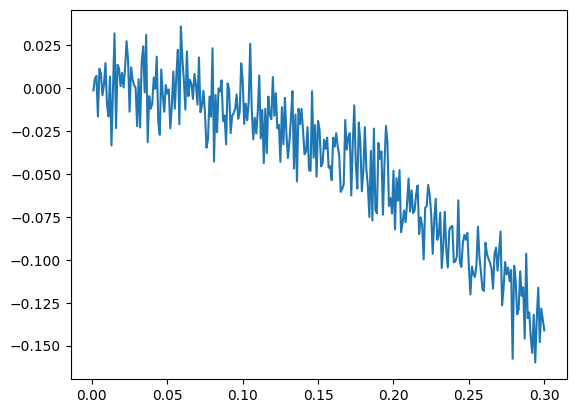

In [129]:
plt.plot(mus, mean_vect)
plt.show()

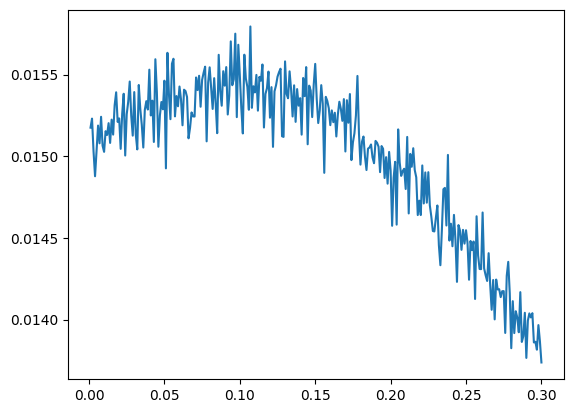

In [130]:
plt.plot(mus, std_vect)
plt.show()

Graph 1 and 2 show that the center of the distribution of the payoff tends to shift to the nagative numbers when we increase $\mu$ but the standard deviation seems to decrease. Graph 1 shows a distinct decrease in the mean as we increase the mean of the stock simulations. This is related to the fact that we assume in the model that the stock returns on average $r$ because we are in a risk neutral environment. Since we don't use $\mu$ to hedge, this means that increasing the mean will just on average increase the cost of the portfolio as the stock will tend to be more expensive but the model predicts a smaller growth.

The decrease in standard deviation from the payoff of the hedge can be explained by the fact that when we increase $\mu$ we decrease the weight of $\sigma$ in the daily variations of the stock price. This gives more stability to the hedge and reduces the variance of the payoff.

### 3- Playing with the volatility

In [131]:
def BlackScholesHedgeMC(S, K, sgm, r, T, callput, mu, n, m):
    w = np.random.standard_normal((n, m))
    St = np.empty((n, m + 1))
    St[:,0] = S
    for i in range(m):
        St[:,i+1] = St[:,i] * np.exp((mu - .5 * 0.3**2) * (T / m) + 0.3 * (w[:,i]) * np.sqrt(T / m))
    payoff = np.apply_along_axis(BlackScholesHedgePath, 1, St, K, sgm, r, T, callput)
    return np.mean(payoff), np.std(payoff) / np.sqrt(n), payoff

sigmas = np.linspace(0.01, 1, 100)
mean_vect = []
std_vect = []
distribution_vect = []

stock,strike,interest,maturity,callput,n, m, mu = 100, 105, 0.02, 2, 1, 10000, 100, 0.07
for sigma in sigmas:
    MC, MCstd, distribution = BlackScholesHedgeMC(
        stock, strike, sigma, interest, maturity, callput, mu, n, m
    )
    mean_vect.append(MC)
    std_vect.append(MCstd)
    distribution_vect.append(distribution)

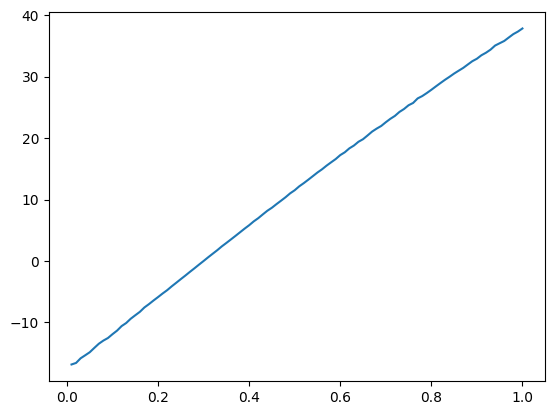

In [132]:
plt.plot(sigmas, mean_vect)
plt.show()

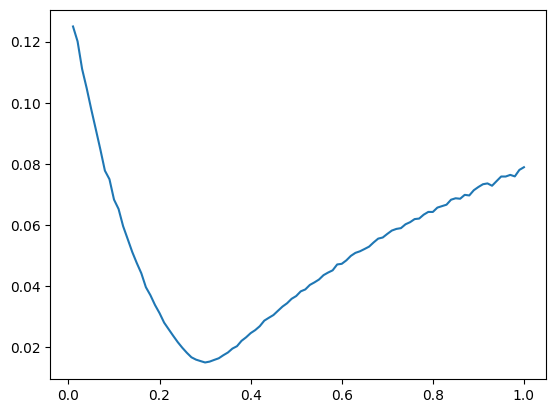

In [133]:
plt.plot(sigmas, std_vect)
plt.show()

When we play with the parameter $\sigma$ of the hedge, we see that the volatility reaches its lowest point when $\sigma_{simulation} = \sigma_{hedge}$. We see that the standard deviation of the distribution decreases when $\sigma_{simulation} > \sigma_{hedge}$ and increases when $\sigma_{simulation} < \sigma_{hedge}$. This can be explained by the fact that we are doing an improper hedge. In fact, when $\sigma_{hedge}$ increases, $d_1$ increases and $d_2$ decreases, making us take less position in the ZCB and more position in the underlying stock. Therefore, we are more and more closely matching the variations of the stocks and by the same time its variance as well. Hence why the sigma is increasing. The same justification is true for when we decrease $\sigma_hedge$, because the $\sigma$ is not sensitive to the sign of the variation. This explains the quadratic variation of the standard deviation of the distribution. 

The same reasonning can be applied to the mean. Indeed, if we take more position of stock, we expect a positive payoff since on average it grows at a rate of $\mu$. On the other hand, if we take less position of the stock, we expect the average of our porfolio to be negative as we are less exposed to the positive variation of the stock.